# Latent Semantic Analysis

## Introduction

Linear algebra plays a pivotal role in various fields, offering powerful tools
and techniques for solving complex problems and extracting meaningful insights from data. One intriguing application of linear algebra in the realm of natural language processing and information retrieval is Latent Semantic Analysis (LSA). LSA is a mathematical and statistical method that involves the application of singular value decomposition (SVD) to large datasets, commonly represented in matrix form, with the aim of uncovering latent semantic structures within the data.

## Dataset


The fetch_20newsgroups dataset from scikit-learn's datasets module is a popular text dataset commonly used for natural language processing and machine learning tasks, particularly for text classification and clustering. This dataset comprises a collection of approximately 20,000 newsgroup documents, spanning 20 different newsgroups or categories. Each newsgroup represents discussions on a specific topic or theme, and the dataset as a whole reflects the diversity of topics discussed in online forums during the late 1990s. In this assignment, We'll only use 5 of the 20 newsgroups for simplicity and efficiency.

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories =  ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.electronics', 'sci.space']
train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

## Demonstration

In [2]:
print(train.data[0])
print(len(train.data))

From: halsall@murray.fordham.edu (Paul Halsall)
Subject: Catholic Liturgy
Reply-To: halsall@murray.fordham.edu
Organization: J. Random Misconfigured Site
Lines: 60


	The problems with Catholic liturgy are likely to continue for
some time.  The problem is, in a nutshell, this: the Liturgy is a
symbolic action - in other words Catholics do [or should] believe that
the _signs_ during the mass - Water, Blessings, Vestments, Altar,
Relics, etc - are real. That is the sprinkling of water bestows real,
almost tangible, holiness, the Vestments are a real indication of real
sacred time. The point of a _symbol_ is that it is understood by all
to be connected to an underlying REAL referent. This kind of thinking
precludes analysis; holy water is not holy because of anything, it
simply IS holy.

But, modern westerners find it extremely difficult, especially if
well- educated, to think of the mass as a symbol. We are more likely
to see it as a _sign_, ie an action that represents grace, but which


## Document-term co-occurrence Matrix

In a document-term co-occurrence matrix, each row corresponds to a document in the dataset, and each column corresponds to a unique term. The entry in cell $M_{ij}$ represents the frequency of term $j$ occurring in document
$i$. Now create the co-occurrence matrix using `CountVectorizer`.
analyze the sparsity of $M$ and $M^TM$.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import issparse
import numpy as np

def vectorize(train_data):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(train_data)
    return vectorizer, X

def analyze(data):
    print(f"Shape: {data.shape}")
    print(f"Is Sparse: {issparse(data)}")
    sparsity = 1.0 - np.count_nonzero(data.toarray()) / float(data.toarray().size)
    print(f"Sparsity: {100 * sparsity: .2f}%")

count_vect, X_train_counts = vectorize(train.data)
analyze(X_train_counts)
C = X_train_counts.T * X_train_counts
analyze(C)

Shape: (2847, 40182)
Is Sparse: True
Sparsity:  99.61%
Shape: (40182, 40182)
Is Sparse: True
Sparsity:  96.20%


## Singular Value Decomposition

The next step involves finding the Singular Value Decomposition (SVD) matrix and embedding the data into a reduced-dimensional space. Describe the process of obtaining the SVD for the document-term co-occurrence matrix. What are the resulting matrices $(U, Σ, V^T)$, and how do they relate to the original matrix.

In [4]:
from scipy.sparse.linalg import svds

k = 2

u, s, vh = svds(C.astype("float"), k)
print(f'U: {u.shape}')
print(f'S: {s.shape}')
print(f'V^H: {vh.shape}')

U: (40182, 2)
S: (2,)
V^H: (2, 40182)


Define the concept of choosing the top-k singular values in the context of the Σ matrix obtained from SVD. What does it mean to truncate the singular values, and how does this process contribute to dimensionality reduction. Discuss the criteria or considerations involved in selecting an appropriate value for k. How might the choice of k impact the quality of the resulting reduced-dimensional space and the representation of latent semantic structures.

> Truncated SVD works by decomposing a matrix into its singular values and vectors,
then selecting only the top k singular values and vectors.
 
> This results in a reduced matrix that captures most of the original information while significantly reducing the number of dimensions.

Calculate the new matrix resulting from the truncated SVD with the chosen top-k singular values.

In [5]:
import numpy as np


B = np.linalg.multi_dot([u, np.diag(s), vh])

Discuss the interpretation of the resulting matrices U and V. How do these matrices contribute to the understanding of semantic relationships between documents and terms.

> Actually U is the distribution of terms across the different contexts,
Whereas VT is the distribution of contexts across the different documents.

## Word Embedding

Word embedding is a technique used to map words from a vocabulary to vectors of real numbers. These vectors capture the semantic relationships between words in a geometric space, where words that share similar meanings are mapped to similar vectors. Word embedding is a popular approach in natural language processing and information retrieval, and is commonly used in the development of language models in machine learning. We use the $i$ th row of $U$ as the embedding vector for the $i$ th word in the vocabulary.

$$ \text{cosine similarity} = \cos{\theta} = \frac{\mathbf{a} . \mathbf{b}}{\| \mathbf{a} \|\| \mathbf{b} \|} $$

In [6]:
vocab = count_vect.vocabulary_

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def word_similarity(word1, word2):
    i = vocab[word1]
    j = vocab[word2]
    return cosine_similarity(u[i], u[j])

print(f"similarity of `god` and `jesus`: {word_similarity('god', 'jesus')}")
print(f"similarity of `god` and `devil`: {word_similarity('god', 'devil')}")
print(f"similarity of `god` and `soccer`: {word_similarity('god', 'soccer')}")
print(f"similarity of `tiger` and `rabbit`: {word_similarity('tiger', 'rabbit')}")
print(f"similarity of `tiger` and `earth`: {word_similarity('tiger', 'earth')}")
print(f"similarity of `star` and `earth`: {word_similarity('star', 'earth')}")

similarity of `god` and `jesus`: 0.9987103687591996
similarity of `god` and `devil`: 0.9982879422191715
similarity of `god` and `soccer`: -0.6782298264133033
similarity of `tiger` and `rabbit`: 0.9412811922091798
similarity of `tiger` and `earth`: 0.42320317694134324
similarity of `star` and `earth`: 0.8168070603061409


## Plot Embeddings

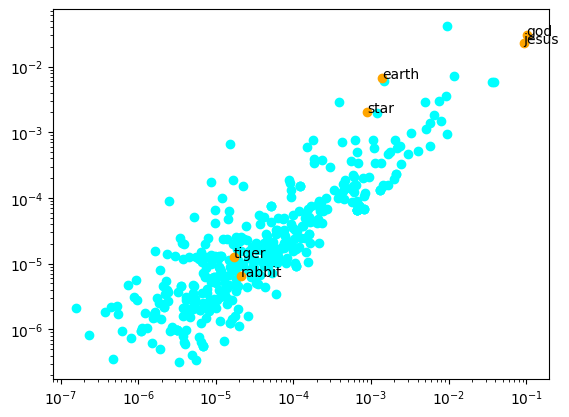

In [7]:
import matplotlib.pyplot as plt

def plot_word(word):
    i = vocab[word]
    vec = u[i]
    ax.scatter(abs(vec[0]), abs(vec[1]), c='orange')
    ax.annotate(word, (abs(vec[0]), abs(vec[1])))
_, ax = plt.subplots()
plt.yscale("log")
plt.xscale("log")
for vec in u[::100]:
    if np.linalg.norm(vec) < 0.1:
        ax.scatter(abs(vec[0]), abs(vec[1]), c='cyan')
plot_word('god')
plot_word('jesus')
plot_word('tiger')
plot_word('rabbit')
plot_word('star')
plot_word('earth')

# Word2Vec (Optional)

Word2Vec is a popular word embedding technique that involves the use of neural networks to learn word embeddings from large datasets. The Word2Vec model is trained on a large corpus of text, and the resulting word vectors demonstrate interesting semantic relationships between words. In this assignment, we'll explore the use of Word2Vec to learn word embeddings from the 20 newsgroups dataset.

Word2Vec is mainly implemented in two ways: continuous bag-of-words (CBOW) and skip-gram. In this assignment, we'll use the CBOW model to train word embeddings on the 20 newsgroups dataset. CBOW predicts the current word based on a window of surrounding context words. The skip-gram model, on the other hand, predicts the surrounding context words based on the current word.

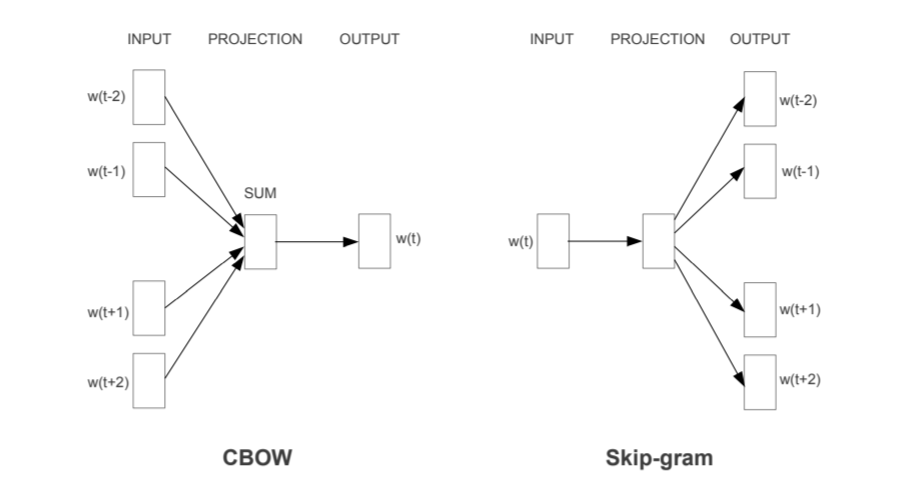

## Preprocessing

We'll remove stopwords and lemmatize the text data using the WordNetLemmatizer from the nltk package. We'll also remove punctuation and convert all text to lowercase.
Then we create a list of windows of context words for each word in the corpus. The size of the window is a hyperparameter that can be tuned to improve the performance of the model. We'll use a window size of 2 for this assignment.

In [9]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def clean_data(train_data):
    cleaned_words = []
    words_index = {}
    for text in train_data:
        text = text.lower()
        text = text.replace('\n', ' ')
        tokenized_data = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        stop_words.update(['.',',',':',';','(',')','#','--','...','"'])
        cleaned_words += [word for word in tokenized_data if word not in stop_words]
    for word in cleaned_words:
        if word not in words_index:
            words_index[word] = len(words_index)
    windows = []
    for i in range(2, len(cleaned_words) - 2):
        window = [cleaned_words[i - 2], cleaned_words[i - 1], cleaned_words[i + 1], cleaned_words[i + 2]]
        window = [words_index[word] for word in window]
        windows.append((window, words_index[cleaned_words[i]]))
    return windows, words_index

windows, words_index = clean_data(train.data)

In [10]:
len(words_index)

48081

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CorpusWindows(Dataset):
    def __init__(self, windows):
        # TODO: store windows
        self.windows = windows

    def __len__(self):
        # TODO: return the number of windows
        return len(self.windows)

    def __getitem__(self, idx):
        # TODO: return the idx-th window and its center word
        return self.windows[idx], 

# TODO: create a dataloader for windows

In [ ]:
from torch import nn

class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        # TODO: initialize embeddings and linear layers
        pass

    def forward(self, inputs):
        # TODO: implement the forward function
        pass
    
    def get_embeddings(self):
        # TODO: return the embeddings
        pass
    
    def get_word_emdedding(self, word):
        # TODO: return the embedding of the word
        pass

In [ ]:
from tqdm import tqdm, trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(words_index)
embedding_dim = 2
model = CBOW(vocab_size, embedding_dim)
model.to(device)
# TODO: initialize the loss function
# TODO: initialize the optimizer

total_loss = 0
pbar = tqdm(train_loader)
for context, target in pbar:
    # TODO: move context and target to device
    # TODO: zero the gradients
    # TODO: forward pass
    # TODO: backward pass
    # TODO: update parameters
    # TODO: update total_loss
    # TODO: update progress bar
    pass

In [ ]:
embeddings = model.embeddings.weight.data.cpu().numpy()

def plot_word(word):
    idx = words_index[word]
    # TODO: plot the word vector
    # add the word label to the plot

print(embeddings.shape)
# plot embeddings
plot_word('god')
plot_word('jesus')
plot_word('tiger')
plot_word('rabbit')
plot_word('star')
plot_word('earth')